In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def Bernsen(imagen, umbralMin, windowSize):
    biny = np.zeros_like(imagen)
    ratioW = windowSize / 2
    for x in range(imagen.shape[0]):
        for y in range(imagen.shape[1]):
            xi = max(0, x- ratioW)
            xf = min(biny.shape[1]-1, x+ratioW)
            yi = max(0, y- ratioW)
            yf = min(biny.shape[0]-1, y+ratioW)
            
            minV = imagen[int(xi), int(yi)]
            maxV = imagen[int(xi), int(yi)]
            
            for i in range(int(xi), int(xf)):
                for j in range(int(yi), int(yf)):
                    value = imagen[i, j]
                    if value < minV:
                        minV = value
                    if value > maxV:
                        maxV = value
            
            umbral = (minV + maxV) / 2
            if umbral >= umbralMin:
                biny[x][y] = 1
            else:
                biny[x][y] = 0
    
    return biny

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

In [21]:
def thresholding(D, threshold): # 0 or 255 since the threshold
    R, G, B = 0, 1, 2

    width_D, height_D= D.shape
    thresholdImg = np.copy(D)
    for row in range(width_D):
        for column in range(height_D):
            if(D[row][column]>threshold):
                thresholdImg[row][column] = 0
            else:
                thresholdImg[row][column] = 1
    
    return thresholdImg

In [22]:
def thresholdingGlobal(D, threshold): # 0 or 255 since the threshold
    upThreshold = []
    downThreshold = [] 
    width_D, height_D = D.shape
    for row in range(width_D):
        for column in range(height_D):
            if(D[row][column]>threshold):
                upThreshold.append(D[row][column])
            else:
                downThreshold.append(D[row][column])
    np.array(upThreshold)
    np.array(downThreshold)
    meanup = np.mean(upThreshold)
    meandown = np.mean(downThreshold)
    newThreshold = (meandown + meanup)/2
    imagen = thresholding(D,newThreshold)
    return imagen

In [23]:


def thresholdOtsu(img): #min(weightB*VarianceB + weightF*VarianceF)
    #Histogram
    hist = np.zeros(256)
    for row in range(img.shape[0]):
        for column in range(img.shape[1]):
            hist[img[row][column]] += 1
    
    pixelesInImg = img.shape[0]*img.shape[1]
    WCVList = []

    #Algorithm
    for threshold in range(len(hist)):
        #b where hist < threshold
        b = hist[:threshold]
        #Weight b
        w_b = sum(b)/(pixelesInImg)
        #Mean b
        m = 0
        for i in range(threshold):
            m += (i*hist[i])
        if(sum(b)==0):
            m_b = 0
        else:
            m_b = m/sum(b)
        #Variance b
        v = 0
        for i in range(threshold):
            v += ((i-m_b)**2) * hist[i]
        if(sum(b)==0):
            v_b = 0
        else:
            v_b = v/sum(b)

        #f where hist >= threshold
        f = hist[threshold:]
        #Weight f
        w_f = sum(f)/(pixelesInImg)
        #Mean f
        m = 0
        for i in range(threshold, len(hist)):
            m += (i*hist[i])
        m_f = m/sum(f)
        #Variance f
        v = 0
        for i in range(threshold, len(hist)):
            v += ((i-m_f)**2) * hist[i]
        v_f = v/sum(f)
        #Within_class_variance
        WCV = (w_b*v_b)+(w_f*v_f)
        WCVList.append(WCV)
        
    t = WCVList.index(min(WCVList))
    imagen = thresholding(img,t)
    return imagen #The rigth threshold

In [27]:
import random

def etiquetas_c(imagen):
    def encontrar_raiz(etiqueta):
        raiz = etiqueta
        while padre[raiz] != raiz:
            raiz = padre[raiz]
        return raiz

    def union(etiqueta1, etiqueta2):
        raiz1 = encontrar_raiz(etiqueta1)
        raiz2 = encontrar_raiz(etiqueta2)
        if raiz1 != raiz2:
            padre[raiz2] = raiz1

    altura, ancho = len(imagen), len(imagen[0])
    padre = list(range(altura * ancho))
    # donde se almacenará la setiquetas
    etiquetas = [[0 for _ in range(ancho)] for _ in range(altura)]
    etiqueta_actual = 1

    for row in range(len(imagen)):
        for col in range(len(imagen[0])):
            if imagen[row][col] == 1:
                vecinos = []
                if row > 0 and etiquetas[row - 1][col] > 0:
                    vecinos.append(etiquetas[row - 1][col])
                if col > 0 and etiquetas[row][col - 1] > 0:
                    vecinos.append(etiquetas[row][col - 1])

                if not vecinos:
                    etiquetas[row][col] = etiqueta_actual
                    etiqueta_actual += 1
                else:
                    etiquetas[row][col] = min(vecinos)
                    for vecino in vecinos:
                        union(etiquetas[row][col], vecino)


    raiz_es = {}
    nueva_e = 1
    #segujda vuelta para encontrar componenetes conectados
    for row in range(altura):
        for col in range(ancho):
            if etiquetas[row][col] > 0:
                raiz = encontrar_raiz(etiquetas[row][col])
                if raiz not in raiz_es:
                    raiz_es[raiz] = nueva_e
                    nueva_e += 1
                etiquetas[row][col] = raiz_es[raiz]

    color = colores(imagen,etiquetas)
    return color
#Colorear las imagenes en función de las etiquetas
def colores(imagen, etiquetas):
    rows, cols = len(imagen), len(imagen[0])
    imagen_color = [[(0, 0, 0) for _ in range(cols)] for _ in range(rows)]

    colores = {}
    for i in range(rows):
        for j in range(cols):
            if etiquetas[i][j] not in colores and etiquetas[i][j] != 0:
                colores[etiquetas[i][j]] = (
                    # los colores se obtine de forma aleatoria
                    random.randint(0, 255),
                    random.randint(0, 255),
                    random.randint(0, 255)
                )
            if etiquetas[i][j] != 0:
                imagen_color[i][j] = colores[etiquetas[i][j]]
    return imagen_color

In [42]:
imagen = cv2.imread('ejemplo3.jpg')
img = np.array(imagen)
imggray= rgb2gray(img)

In [43]:
UmbralX = thresholdingGlobal(imggray, 110)
Otsu= thresholdOtsu(imggray)
bensenU = Bernsen(imggray, 50, 3)

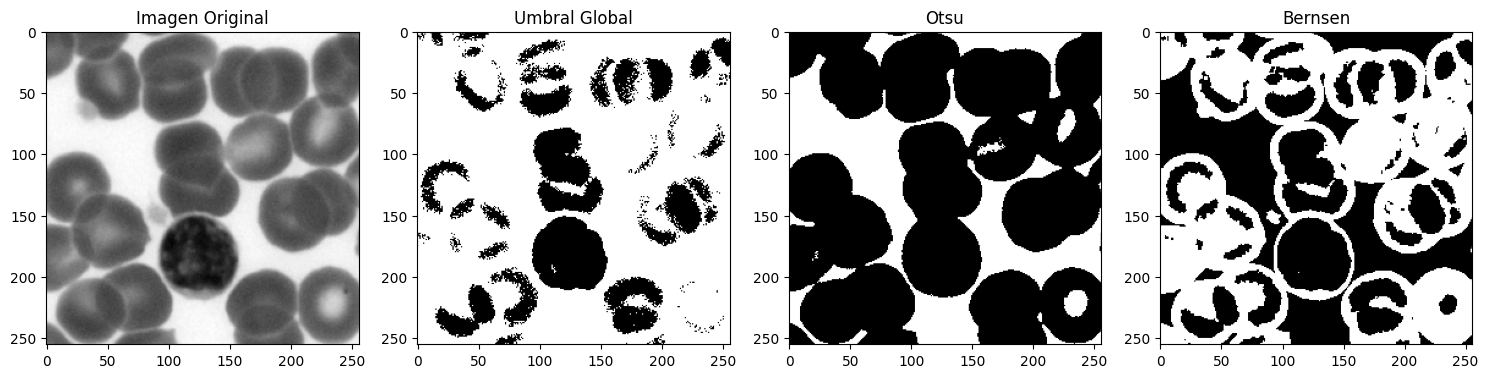

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # Ajusta el tamaño de la figura según tus necesidades

axs[0].imshow(imggray, cmap='gray')
axs[0].set_title('Imagen Original') 

axs[1].imshow(UmbralX, cmap='binary')
axs[1].set_title('Umbral Global') 

axs[2].imshow(Otsu, cmap='binary')
axs[2].set_title('Otsu')  

axs[3].imshow(bensenU, cmap='binary')
axs[3].set_title('Bernsen')  

plt.tight_layout()

plt.show()

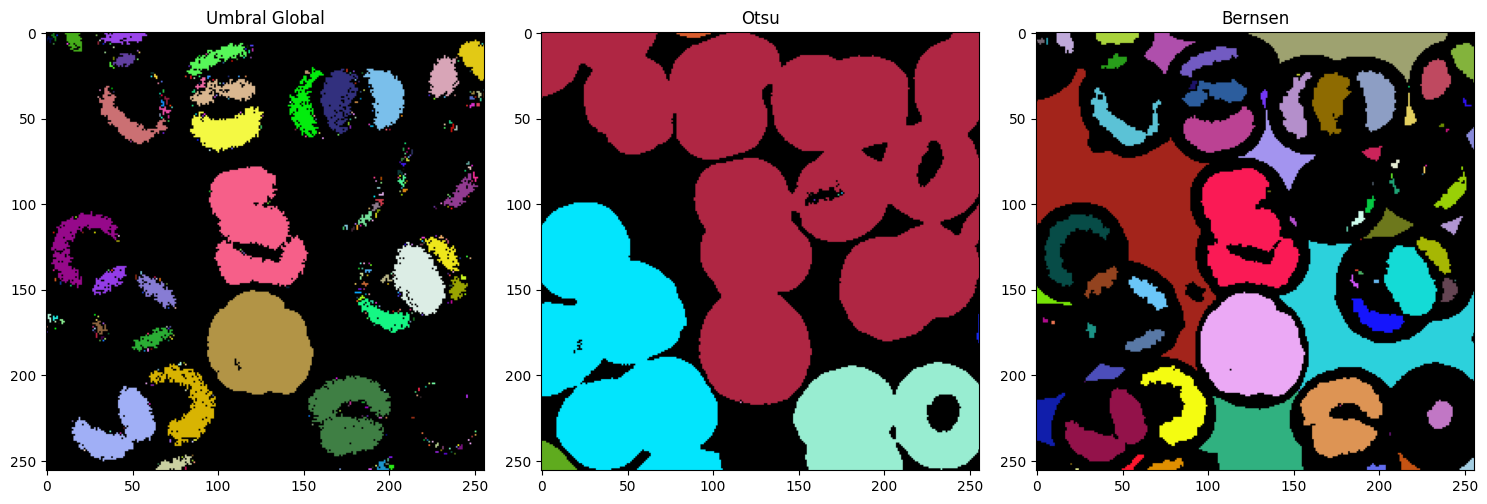

In [ ]:


globall = etiquetas_c(UmbralX)
Otsu= etiquetas_c(Otsu)
bensenU = etiquetas_c(bensenU)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(globall)
axs[0].set_title('Umbral Global') 

axs[1].imshow(Otsu)
axs[1].set_title('Otsu') 

axs[2].imshow(bensenU)
axs[2].set_title('Bernsen')  
 

plt.tight_layout()

plt.show()